# CS684 - Final Project
## Unsupervised depth estimation from stereo pairs

#### Rowan Dempster and Gustavo Sutter

### Abstract

Self supervised learning (SSL) can be applied to disparity estimation by reconstructing the left image by inverse warping the right image, taking care to apply an occlusion mask, and generating a reconstruction loss. However, even under a ground truth disparity map, the pixels of the reconstructed left image may not perfectly match the pixels of the observed left image due to shadows, reflections, etc.. which change between the left and right view points. Thus, we should not expect a pixel based reconstruction loss to converge to the desired solution for such surfaces where the “color consistency” assumption between view points does not hold. 

In this report we study the above problem, first examining motivating examples of cases where the color consistency assumption does not hold, and presenting a possible solution based on “perceptual loss”. We then implement our own SSL training pipeline with disparity estimation model based on xxx, and provide results of a large suite of experiments which analyze the efficacy of different loss function designs. We found that … conclusions 

In [1]:
# Create IRS/lists/IRS_metal_test.list for our usage
from pathlib import Path

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tabulate
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import sys
sys.path.append('extlibs/')

from IRS.dataloader.IRSLoader import IRSDataset
from IRS.networks.DispNetC import DispNetC
from IRS.losses.multiscaleloss import EPE

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DEVICE = 'cuda:0'
DATA_DIR = "/data"
VALIDATION_LIST = 'extlibs/IRS/lists/IRS_restaurant_metal_test.list'

### Dataset

The IRS dataset contains rectified stereo pairs of indoor simulated environments, as well as ground truth disparity maps

In [5]:
# Loading the dataset
dataset = IRSDataset(txt_file=VALIDATION_LIST, 
                     root_dir=DATA_DIR, 
                     phase='visualize')

Text(0, 0.5, 'True disparity')

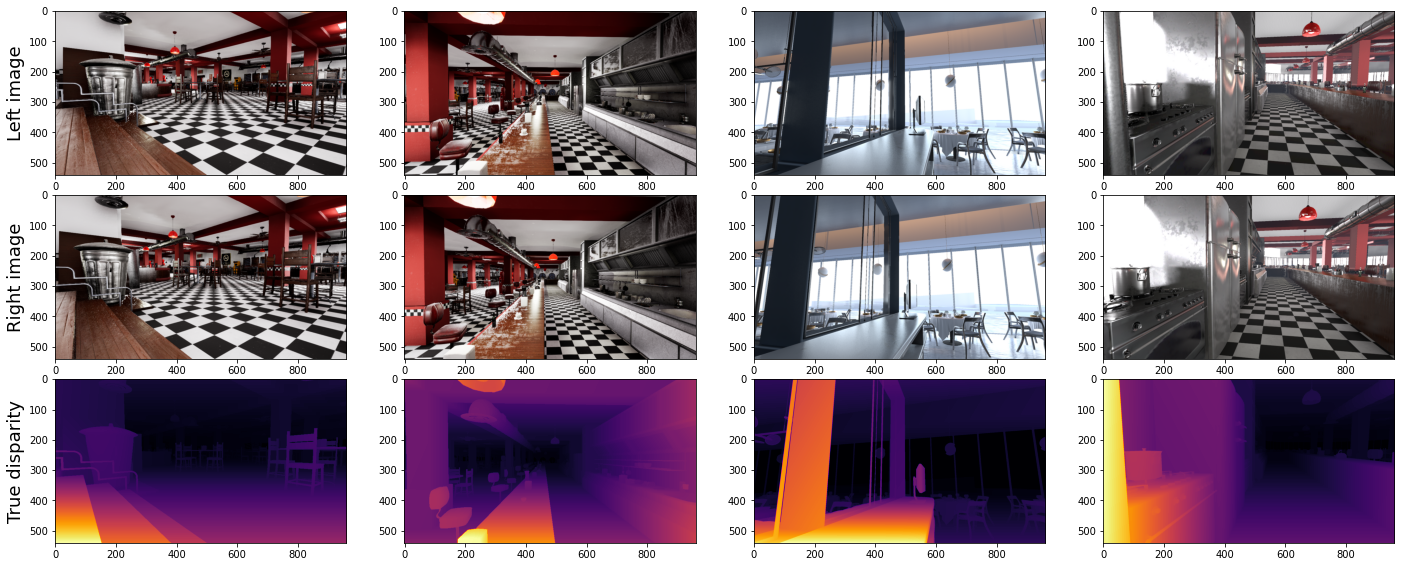

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(24, 10))
fig.subplots_adjust(hspace=0.05)

selected_samples = [8, 12, 15, 26]
for i, idx in enumerate(selected_samples):
    sample = dataset[idx]
    ax[0, i].imshow(sample['img_left'].permute(1, 2, 0))
    ax[1, i].imshow(sample['img_right'].permute(1, 2, 0))
    ax[2, i].imshow(sample['gt_disp'].permute(1, 2, 0), cmap='inferno')

ax[0, 0].set_ylabel('Left image', fontsize=18)
ax[1, 0].set_ylabel('Right image', fontsize=18)
ax[2, 0].set_ylabel('True disparity', fontsize=18)

### Unsupervised learning

We are tackling stereo disparity estimation as a unsupervised learning problem, which means that we are not interest in using the true disparity during the training phase. Therefore, during training the two views are the only data used to learn the structure of the scene. That is a much more realistic strategy, as in most applications collecting a real dataset with dense disparity maps requires specialized hardware and still exhibits some inperfections.

Reconstructing one of the views given the other can be used as supervision signal to replace the ground-truth disparitied. More concretely, the idea is that the disparity maps indicates how the pixels between the two images connect to each other. Therefore, given the left view $I^{L}$ we can use its predicted disparity $\hat{d}^L$ to create a reconstructed version of the left view reprojecting the right view, $\hat{I}^{L} = Repr(I^R, \hat{d}^L)$. The reprojection basically consists of shifting the pixels of the right images according the disparity, being careful about the disparity values to deal with occlusions. The following image demonstrates how the reconstruction works on a simple 1D example: 

MOSTRAR IMAGEM EXPLICANDO COMO É FEITO E EXPLICAR

The following piece of code shows a real images from the dataset and the resulting reconstruction

In [8]:
from mylibs.reconstruction import estimate_left

In [9]:
idx = 26
sample = dataset[idx]
im_l, im_r, disp = sample['img_left'], sample['img_right'], sample['gt_disp']
im_l, im_r, disp = im_l.unsqueeze(0), im_r.unsqueeze(0), disp.unsqueeze(0)

est_l = estimate_left(im_l, im_r, disp)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


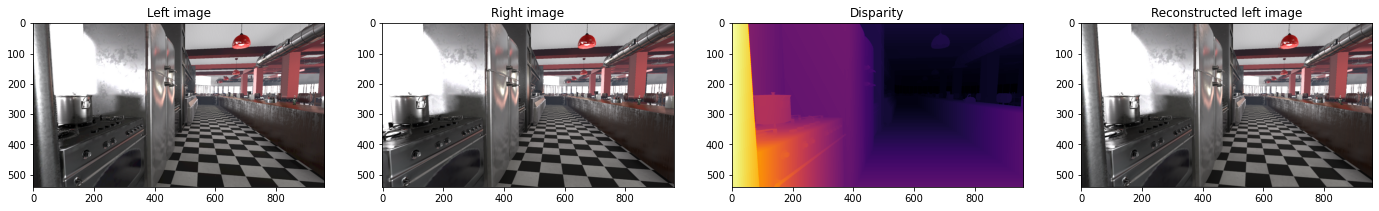

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))

ax[0].imshow(im_l[0].permute(1, 2, 0))
ax[0].set_title('Left image')

ax[1].imshow(im_r[0].permute(1, 2, 0))
ax[1].set_title('Right image')

ax[2].imshow(disp[0].permute(1, 2, 0), cmap='inferno')
ax[2].set_title('Disparity')

ax[3].imshow(est_l[0].permute(1, 2, 0))
ax[3].set_title('Reconstructed left image');

### Loss function visualization

Text(0, 0.5, 'True disparity')

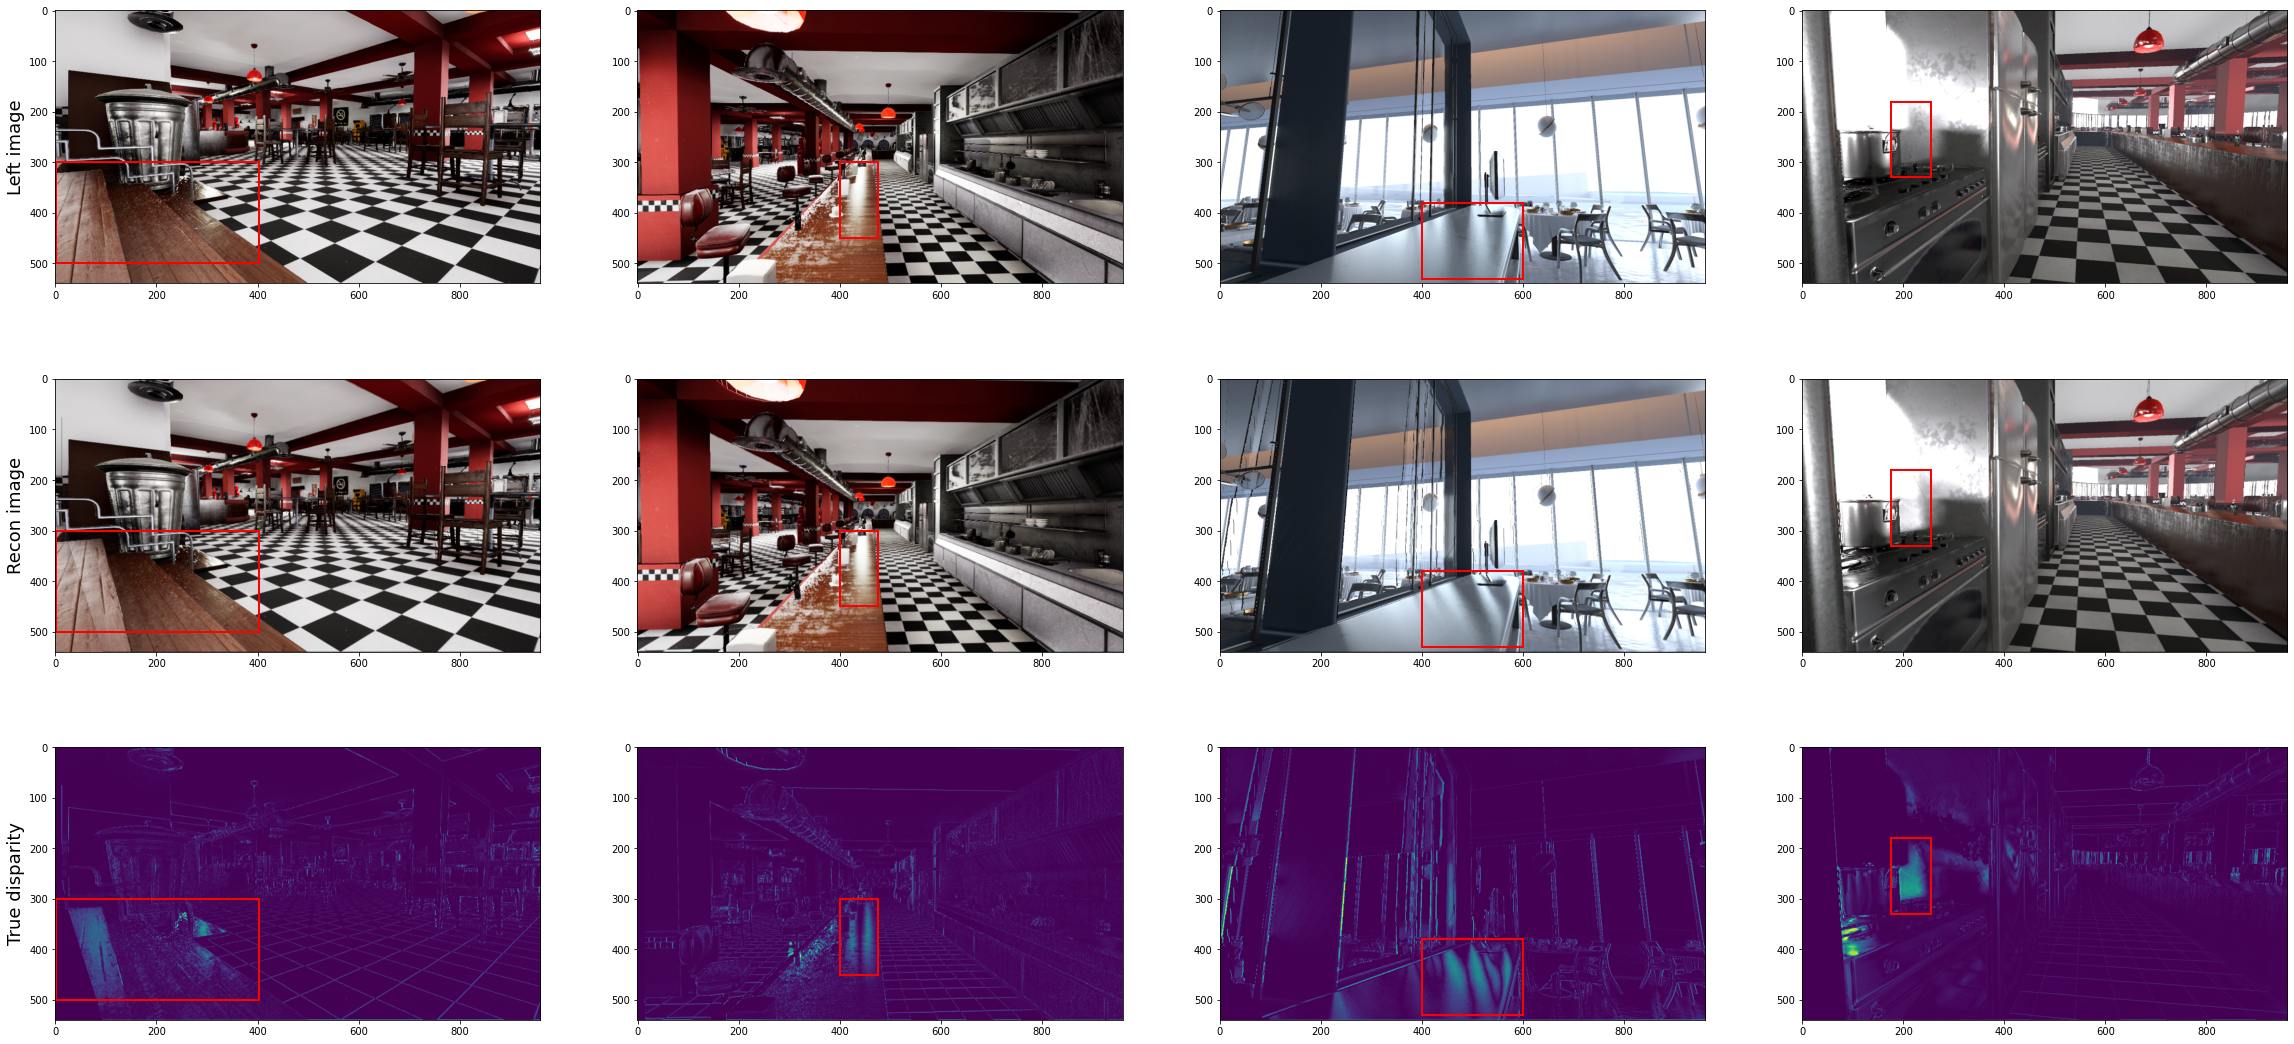

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(40, 20))
fig.subplots_adjust(hspace=0.05)

selected_samples = [8, 12, 15, 26]
rect_dict = {idx: 
    patches.Rectangle((box[0], box[1]), box[2], box[3], 
    linewidth=2, edgecolor='red', facecolor='none') 
    for idx, box in zip(selected_samples, [[2, 300, 400, 200], [400, 300, 75, 150], [400, 380, 200, 150], [175, 180, 80, 150]])
}
for i, idx in enumerate(selected_samples):
    sample = dataset[idx]
    im_l, im_r, disp = sample['img_left'].to(DEVICE), sample['img_right'].to(DEVICE), sample['gt_disp'].to(DEVICE)
    ax[0, i].imshow(im_l.permute(1, 2, 0).cpu())
    ax[0, i].add_patch(deepcopy(rect_dict[idx]))
    est_l = estimate_left(im_l.unsqueeze(0), im_r.unsqueeze(0), disp.unsqueeze(0)).squeeze()
    ax[1, i].imshow(est_l.permute(1, 2, 0).cpu())
    ax[1, i].add_patch(deepcopy(rect_dict[idx]))
    l1_loss = torch.abs(est_l - im_l).norm(dim=0,p=1)
    ax[2, i].imshow(l1_loss.cpu())
    ax[2, i].add_patch(deepcopy(rect_dict[idx]))

ax[0, 0].set_ylabel('Left image', fontsize=18)
ax[1, 0].set_ylabel('Recon image', fontsize=18)
ax[2, 0].set_ylabel('True disparity', fontsize=18)

In [13]:
from mylibs.losses import PerceptualLoss

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

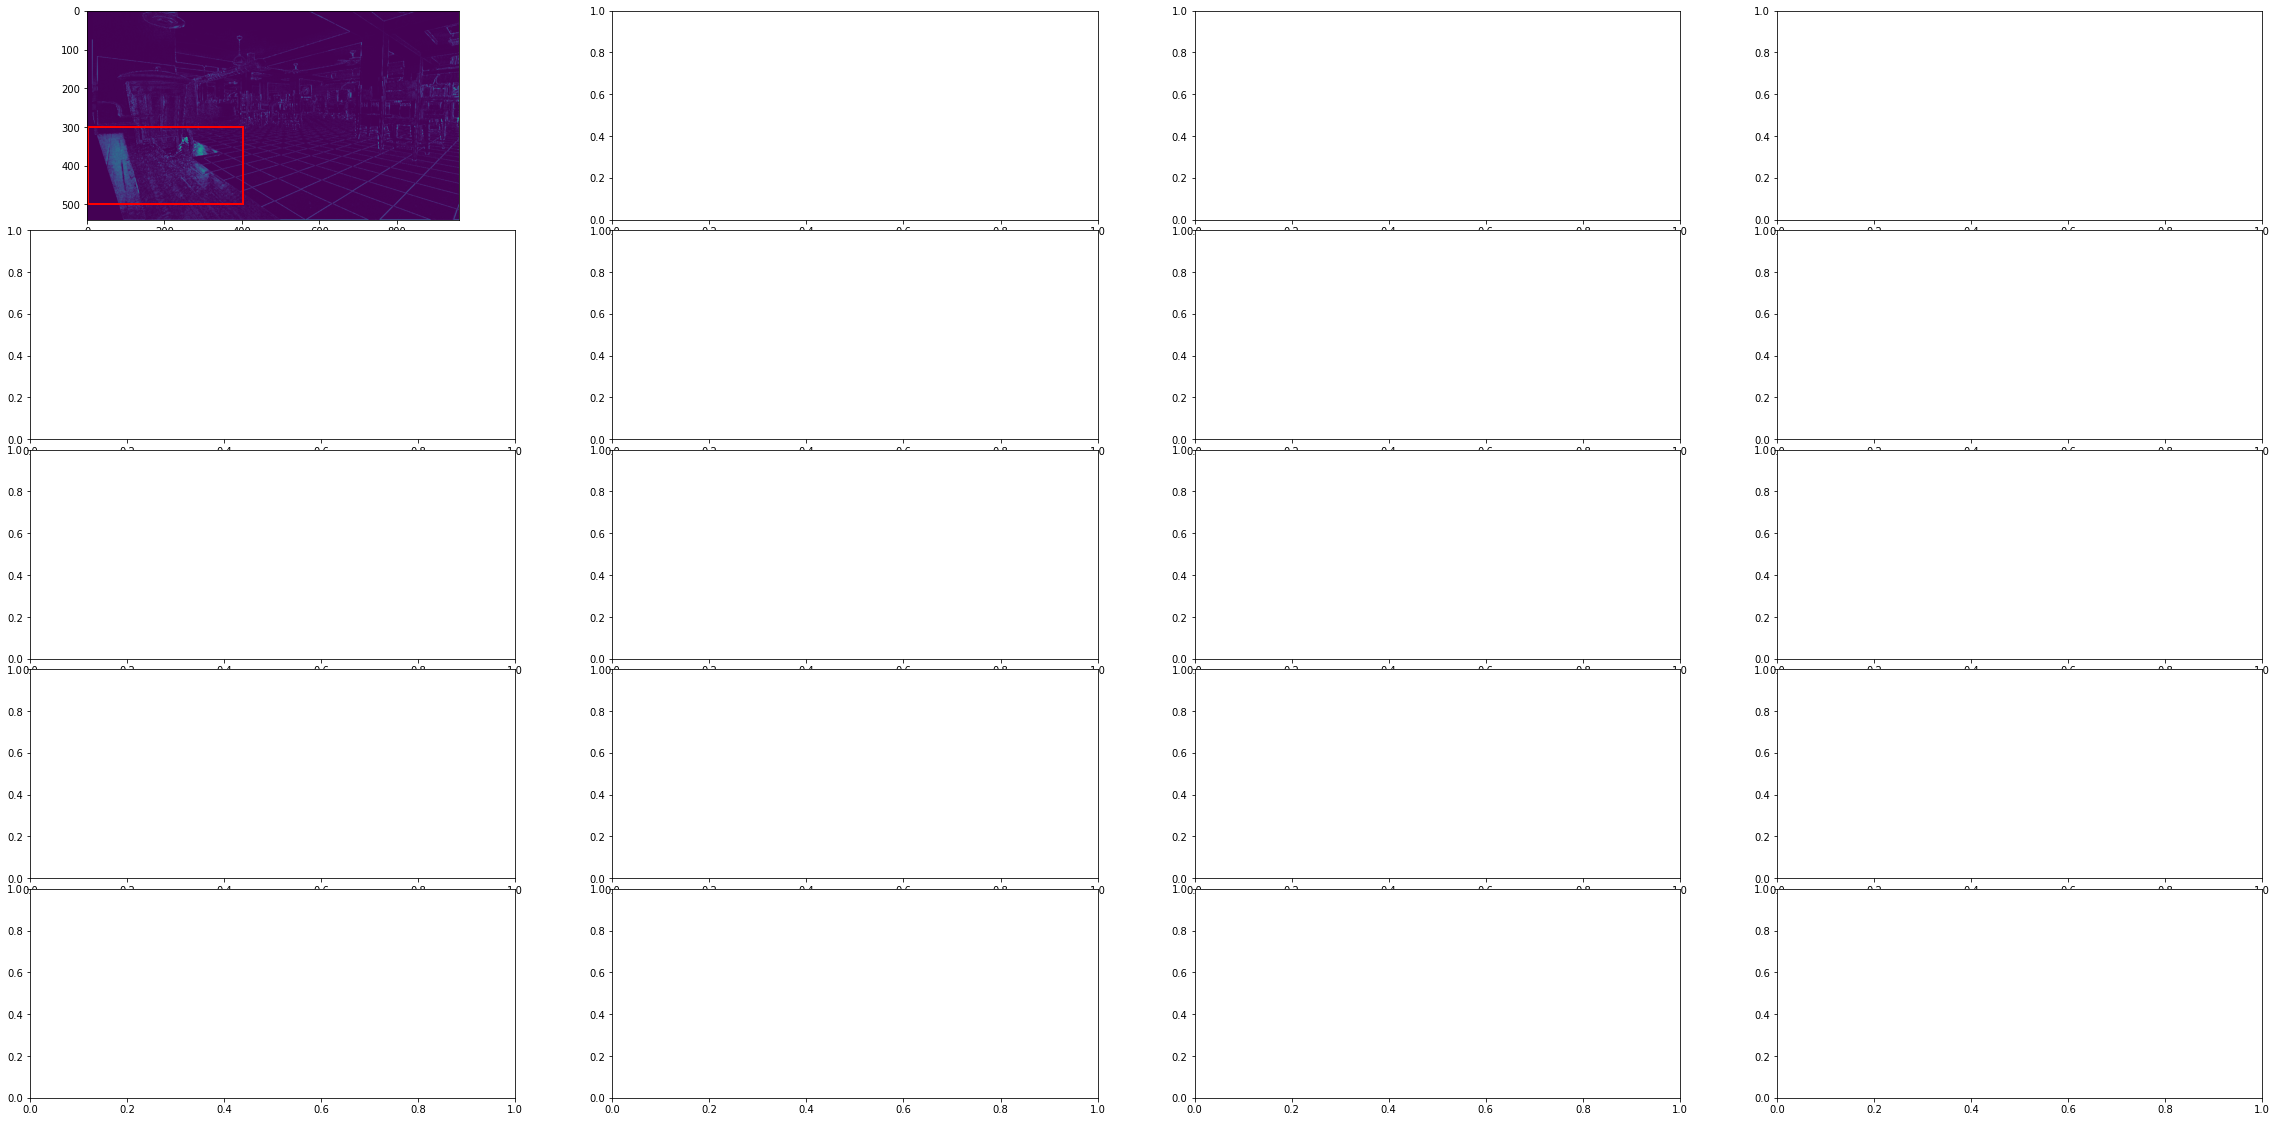

In [15]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(40, 20))
fig.subplots_adjust(hspace=0.05)

selected_samples = [8, 12, 15, 26]
rect_dict = {idx: 
    patches.Rectangle((box[0], box[1]), box[2], box[3], 
    linewidth=2, edgecolor='red', facecolor='none') 
    for idx, box in zip(selected_samples, [[2, 300, 400, 200], [400, 300, 75, 150], [400, 380, 200, 150], [175, 180, 80, 150]])
}
p1 = PerceptualLoss([PerceptualLoss.L1], DEVICE)
p2 = PerceptualLoss([PerceptualLoss.L2], DEVICE)
p3 = PerceptualLoss([PerceptualLoss.L3], DEVICE)
p4 = PerceptualLoss([PerceptualLoss.L4], DEVICE)
for i, idx in enumerate(selected_samples):
    sample = dataset[idx]
    im_l, im_r, disp = sample['img_left'], sample['img_right'], sample['gt_disp']
    est_l = estimate_left(im_l.unsqueeze(0), im_r.unsqueeze(0), disp.unsqueeze(0)).squeeze()
    l1_loss = torch.abs(est_l - im_l).norm(dim=0,p=1)
    ax[0, i].imshow(l1_loss.cpu())
    ax[0, i].add_patch(deepcopy(rect_dict[idx]))
    p1_loss = p1(im_l.unsqueeze(0), im_r.unsqueeze(0), disp.unsqueeze(0)).squeeze()
    ax[1, i].imshow(p1_loss.detach().cpu())
    ax[1, i].add_patch(deepcopy(rect_dict[idx]))
    p2_loss = p2(im_l.unsqueeze(0), im_r.unsqueeze(0), disp.unsqueeze(0)).squeeze()
    ax[2, i].imshow(p2_loss.detach().cpu())
    ax[2, i].add_patch(deepcopy(rect_dict[idx]))
    p3_loss = p3(im_l.unsqueeze(0), im_r.unsqueeze(0), disp.unsqueeze(0)).squeeze()
    ax[3, i].imshow(p3_loss.detach().cpu())
    ax[3, i].add_patch(deepcopy(rect_dict[idx]))
    p4_loss = p4(im_l.unsqueeze(0), im_r.unsqueeze(0), disp.unsqueeze(0)).squeeze()
    ax[4, i].imshow(p4_loss.detach().cpu())
    ax[4, i].add_patch(deepcopy(rect_dict[idx]))

ax[0, 0].set_ylabel('L1', fontsize=18)
ax[1, 0].set_ylabel('Per Layer 1', fontsize=18)
ax[2, 0].set_ylabel('Per Layer 2', fontsize=18)
ax[3, 0].set_ylabel('Per Layer 3', fontsize=18)
ax[4, 0].set_ylabel('Per Layer 4', fontsize=18)

### Experimental framework


We used the network architeture from XXXXX [Y], it receives the two views concatened along the channel axis and outputs the predict disparity map. A large portion of our work was done on the study of different loss functions to the problem. We experimented with the following loss functions:

**L1 Loss**:

$$\mathcal{L}_{L1} = \sum_{i,j} |I^L_{ij} - \hat{I}^L_{ij}|$$

**Disparity smoothness loss**: 

$$\mathcal{L}_{smooth} = \sum_{i,j} |\nabla_x \hat{d}^L_{ij}| e^{-\nabla_x \hat{I}^L_{ij}} + |\nabla_y \hat{d}^L_{ij}| e^{-\nabla_y \hat{I}^L_{ij}}$$

**Perceptual loss**: 

$$\mathcal{L}_{per} = \sum_k \sum_{i,j} |\phi_k(I^L)_{ij} - \phi_k(\hat{I}^L)_{ij}|$$

In theory we should be able to apply a multiscale loss scheme, however due to computational constraints we calculated the loss on the final image resolution. 

### Results

In [10]:
def load_model(path, device):
    state_dict = torch.load(path, map_location=device)
    state_dict, epe = state_dict['model'], state_dict['epe']
    model = DispNetC(batchNorm=False, input_channel=3, maxdisp=194).to(device)
    model.load_state_dict(state_dict)
    model = model.eval()
    return model, epe


def run_inference(net, im_l, im_r, scale_size, device):
    im_l, im_r = im_l.to(device), im_r.to(device)
    im_l, im_r = im_l.unsqueeze(0), im_r.unsqueeze(0)

    im_l = F.interpolate(im_l, scale_size, mode="bilinear")
    im_r = F.interpolate(im_r, scale_size, mode="bilinear")

    input = torch.cat((im_l, im_r), 1)       
    with torch.no_grad():
        pred_disp = net(input)[0]

    pred_disp = pred_disp.squeeze(0)
    pred_disp = pred_disp.cpu()
    
    return pred_disp

def run_validation(net, loader, device):
    net.eval()
    total = 0
    n = 0

    for batch in tqdm(loader):
        batch = {name: tensor.to(device) for name, tensor in batch.items()}
        left_input, right_input, target_disp = batch["img_left"], batch["img_right"], batch["gt_disp"]

        left_input = F.interpolate(left_input, loader.dataset.scale_size, mode="bilinear")
        right_input = F.interpolate(right_input, loader.dataset.scale_size, mode="bilinear")

        input = torch.cat((left_input, right_input), 1)       
        with torch.no_grad():
            disp = net(input)[0]

        # upsampling the predicted disparity map
        disp = nn.Upsample(size=target_disp.shape[2:], mode='bilinear')(disp)
        epe = EPE(disp, target_disp)

        # record loss and EPE
        total += epe.data.item()
        n += input.size(0)

    return total / n


def create_result_table(results):
    map_to_fig = {True: '✓', False: '✗'}
    results = [[map_to_fig[r] if type(r) == bool else r for r in res] for res in results]
    results = [[f'{r: .4f}' if type(r) == float else r for r in res] for res in results]
    results_table = tabulate.tabulate(results, headers=['L1', 'Perceptual', 'Smooth', 'EPE'], tablefmt='html', colalign= 4 * ["center"])
    return results_table

In [11]:
# Flag to indicate if the metric should be run again or just use the one saved with the model
RECOMPUTE_EPE = False

# Creating dataset and dataloader
dataset = IRSDataset(txt_file=VALIDATION_LIST, root_dir=DATA_DIR, phase='test', load_norm=False)
loader = DataLoader(dataset, batch_size=4, shuffle=False, pin_memory=True)

# Defining the list of experiments to be evaluated
configs = [
    {'path': '/project/ckpts/l123_prod/dispnet_epoch_7', 'l1': True, 'per': False, 'smooth': True},
    {'path': '/project/ckpts/l123_prod/dispnet_epoch_7', 'l1': True, 'per': 'L1', 'smooth': True},
    {'path': '/project/ckpts/l123_prod/dispnet_epoch_7', 'l1': True, 'per': 'L1 and L2', 'smooth': True},
    {'path': '/project/ckpts/l123_prod/dispnet_epoch_7', 'l1': True, 'per': 'L1, L2, L3', 'smooth': True},
]

# Defining the samples to be used for inference
sample_idx_list = [0, 1]

In [12]:
# List to store the disparities produced by the models
inference_results = []

# Loading experiments weights and computing the evalutation metric
results = []
for config in configs:
    model, epe = load_model(config['path'], DEVICE)
    if RECOMPUTE_EPE:
        epe = run_validation(model, loader, DEVICE)
    
    disps = []
    for idx in sample_idx_list:
        sample = dataset[idx]
        im_l, im_r = sample["img_left"], sample["img_right"]
        disp = run_inference(model, im_l, im_r, dataset.scale_size, DEVICE)
        disps.append(disp)

    results.append([config['l1'], config['per'], config['smooth'], epe])
    inference_results.append(disps)


# Transpose list of results
inference_results = list(map(list, zip(*inference_results)))

# Creating a table with the results and displaying it
results_table = create_result_table(results)
results_table

/project/IRS/networks/DispNetC.py:117: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(m.weight.data)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


'<table>\n<thead>\n<tr><th style="text-align: center;"> L1 </th><th style="text-align: center;"> Perceptual </th><th style="text-align: center;"> Smooth </th><th style="text-align: center;"> EPE  </th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: center;"> ✓  </td><td style="text-align: center;">     ✗      </td><td style="text-align: center;">   ✓    </td><td style="text-align: center;">8.3854</td></tr>\n<tr><td style="text-align: center;"> ✓  </td><td style="text-align: center;">     L1     </td><td style="text-align: center;">   ✓    </td><td style="text-align: center;">8.3854</td></tr>\n<tr><td style="text-align: center;"> ✓  </td><td style="text-align: center;"> L1 and L2  </td><td style="text-align: center;">   ✓    </td><td style="text-align: center;">8.3854</td></tr>\n<tr><td style="text-align: center;"> ✓  </td><td style="text-align: center;"> L1, L2, L3 </td><td style="text-align: center;">   ✓    </td><td style="text-align: center;">8.3854</td></tr>\n</tbody>\n</table>'

In [13]:
def denormalize_img(im):
    mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = torch.Tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    return im * std + mean 
    

def show_results_grid(im_l, im_r, gt_disp, results_disps, names, box=None):
    layout = [['im_l', 'd1', 'd2', 'd3', 'd4','d5'],
              ['im_r', 'd1', 'd2', 'd3', 'd4','d5']]

    fig, ax = plt.subplot_mosaic(layout, figsize=(35, 8))

    ax['im_l'].imshow(im_l.permute(1, 2, 0))
    ax['im_l'].set_title('Left image')
    ax['im_r'].imshow(im_r.permute(1, 2, 0))
    ax['im_r'].set_title('Right image')    

    keys = ['d1', 'd2', 'd3', 'd4','d5']
    disps = [gt_disp] + results_disps
    names = ['Ground-truth'] + names
    for key, disp, name in zip(keys, disps, names):
        ax[key].imshow(disp.permute(1, 2, 0), cmap='inferno')
        ax[key].set_title(name)
        if box != None:
            rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='r', facecolor='none')
            ax[key].add_patch(rect)

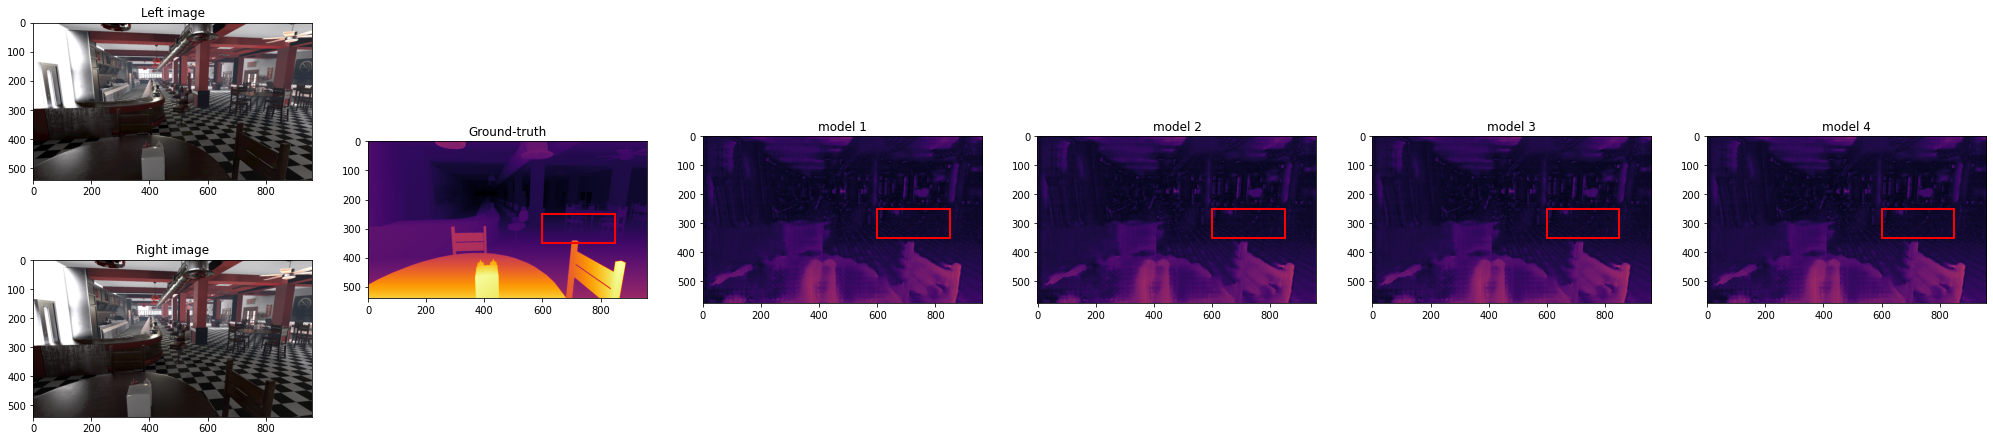

In [14]:
names = ['model 1', 'model 2', 'model 3', 'model 4']

idx = 0
sample = dataset[sample_idx_list[idx]]
im_l, im_r, disp = sample["img_left"], sample["img_right"], sample['gt_disp']
im_l, im_r = denormalize_img(im_l), denormalize_img(im_r)

show_results_grid(im_l, im_r, disp, inference_results[idx], names, [600, 250, 250, 100])

### Conclusion

### References

[1] Reference 1

[2] Reference 2

[3] Reference 3

[4] Reference 4

[5] Reference 5

[6] Reference 6